# slice finder

当我们有了Hypergraph、connectivity graph、order以及contraction tree之后，我们可以进行slice的选择。

首先，我们需要设计一个函数，估计slice某个边之后的计算成本。

In [ ]:
import stim
circuit_noisy = stim.Circuit.from_file("../data/external/google23/surface_code_bZ_d3_r01_center_3_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

from hamld.contraction_strategy.dem_to_hypergraph import DetectorErrorModelHypergraph
hypergraph = DetectorErrorModelHypergraph(detector_error_model=detector_error_model, have_logical_observable= True)
from hamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph
connectivity_graph = ConnectivityGraph()
connectivity_graph.hypergraph_to_connectivity_graph(hypergraph)
from hamld.contraction_strategy.mld_order_finder import GreedyMLDOrderFinder
order_finder = GreedyMLDOrderFinder(connectivity_graph)
order = order_finder.find_order()

from hamld.contraction_strategy.contraction_tree import ContractionTree
contraction_tree = ContractionTree(order, detector_error_model=detector_error_model)
print(f"contraction_tree contraction_cost:{contraction_tree.contraction_cost}")
print(f"contraction_tree contraction_cost_each_step:{contraction_tree.contraction_cost_each_step}")

contraction_tree contraction_cost:35
contraction_tree contraction_cost_each_step:{'D1': 4, 'D3': 8, 'D5': 4, 'D0': 8, 'D7': 4, 'D2': 4, 'D4': 2, 'D6': 1}


在某些情况下，{'D1': 4, 'D5': 8, 'D3': 4, 'D0': 8, 'D7': 4, 'D4': 4, 'D6': 2, 'D2': 1}
D3和D5等价，二者有没有区别？

In [2]:
sorted_edge_contractions = sorted(contraction_tree.edge_contractions, key=lambda x: x[2] - x[1], reverse= True)
print(sorted_edge_contractions)

[(('D0', 'D4'), 3, 6), (('D3', 'D7'), 1, 4), (('D0', 'D2'), 3, 5), (('D0', 'D3'), 1, 3), (('D1', 'D5'), 0, 2), (('D2', 'D6'), 5, 7), (('D4', 'D7'), 4, 6), (('D5', 'D7'), 2, 4), (('D0', 'D5'), 2, 3), (('D0', 'D7'), 3, 4), (('D1', 'D3'), 0, 1), (('D2', 'D4'), 5, 6), (('D2', 'D7'), 4, 5), (('D3', 'D5'), 1, 2), (('D4', 'D6'), 6, 7), (('D0', 'L0'), 3, 3), (('D1', 'L0'), 0, 0), (('D2',), 5, 5), (('D3',), 1, 1), (('D4', 'L0'), 6, 6), (('D5', 'L0'), 2, 2), (('D6',), 7, 7), (('D7',), 4, 4)]


我们假设slice sorted_edge_contractions[0][0]超边('D0', 'D5')之后，对应的连通图收缩成本为多少？

In [3]:
sliced_hyperedges = [sorted_edge_contractions[0][0]]

In [4]:
sliced_hyperedges

[('D0', 'D4')]

In [ ]:
from hamld.contraction_strategy.slice_finder import SliceFinder

slice_finder = SliceFinder(contraction_tree)
contraction_cost, contraction_width = slice_finder.compute_node_contraction_cost_by_sliced_hypergraph(order=order, hypergraph = hypergraph, sliced_hyperedges=sliced_hyperedges)

In [6]:
sorted(contraction_tree.edge_contractions, key=lambda x: x[2] - x[1], reverse= True)

[(('D0', 'D4'), 3, 6),
 (('D3', 'D7'), 1, 4),
 (('D0', 'D2'), 3, 5),
 (('D0', 'D3'), 1, 3),
 (('D1', 'D5'), 0, 2),
 (('D2', 'D6'), 5, 7),
 (('D4', 'D7'), 4, 6),
 (('D5', 'D7'), 2, 4),
 (('D0', 'D5'), 2, 3),
 (('D0', 'D7'), 3, 4),
 (('D1', 'D3'), 0, 1),
 (('D2', 'D4'), 5, 6),
 (('D2', 'D7'), 4, 5),
 (('D3', 'D5'), 1, 2),
 (('D4', 'D6'), 6, 7),
 (('D0', 'L0'), 3, 3),
 (('D1', 'L0'), 0, 0),
 (('D2',), 5, 5),
 (('D3',), 1, 1),
 (('D4', 'L0'), 6, 6),
 (('D5', 'L0'), 2, 2),
 (('D6',), 7, 7),
 (('D7',), 4, 4)]

## 实现多步的slice

我们存在可并行线程（并行度），我们考虑利用slice，来达到简单网络结构的目标，从而实现更高效的compute。

我们假设，我们定义并行度为：
sliced_hyperedge_count = len(sliced_hyperedges)
parallel_count = 2**sliced_hyperedges_number

CPU一般的线程数为：
* 几十个到几百个并行线程

GPU的并行度通常取决于其核心数、每个SM（流多处理器）支持的线程束（warp）数、线程块（block）的最大大小等因素:
* NVIDIA A100 GPU（Ampere架构）有 108个SM，每个SM支持 128个线程束，每个线程束有 32个线程，所以最大并行线程数是：108×128=13824 个并行Core
* NVIDIA Tesla V100 GPU（Volta架构）有 80个SM，每个SM支持 64个线程束，所以最大并行线程数为：80×64=5120 个并行Core。

![image.png](./figures/CPU_GPU.png)

GPU并行度非常高，适合执行 数据并行 型任务（例如，相同程序的多个输入），并且通常 内存带宽 也非常高，能支持大量数据的并行计算。

关于合并：GPU上的合并操作：如果计算结果较简单，合并操作可能会在GPU上通过额外的线程来完成，但通常，如果合并逻辑比较复杂，可能会将结果传输回CPU进行合并，特别是在需要进行 排序 或复杂聚合时。

在HAMLD中，合并逻辑非常简单。

1. 线程级并行（Thread-Level Parallelism, TLP）：线程是最小的并行执行单元。在同一进程中，多个线程可以共享进程内存，通常用于密集型计算任务。每个线程执行相同的任务，但使用不同的数据。
2. 进程级并行（Process-Level Parallelism, PLP）：进程是操作系统分配资源的基本单元。不同进程之间通常有独立的内存空间。进程级并行用于将多个相对独立的计算任务在不同的CPU核心或者机器上运行。

在HAMLD中，描述的是多个任务执行相同的计算程序，每个任务有不同的输入数据。这个场景属于 线程级并行，因为多个线程可以在同一进程中并行执行相同的计算任务，不同的是它们的输入数据不同。

目前服务器的CPU = 72*2。

目前服务器GPU为6个V100：5120 CUDA 核心 × 6 GPU = 30,720 个并行FP32线程，FP64为2560*具体可以参考：https://www.nvidia.cn/content/dam/en-zz/zh_cn/Solutions/Data-Center/volta-gpu-architecture/Volta-Architecture-Whitepaper-v1.1-CN.compressed.pdf。

核心的问题：在GPU中，一个core就是一个MLD任务的执行单元吗，还是一个线程？

我们首先假设，我们考虑CPU并行，$2^7=128$, $2^5=32$。
因此我们slice 5、6、7个超边。

In [7]:
# meaning len(sliced_hyperedges) <= sliced_hyperedge_count
sliced_hyperedge_count = 5
parallel_count = 2**sliced_hyperedge_count
print(f"sliced_hyperedge_count: {sliced_hyperedge_count}, parallel_count: {parallel_count}")

sliced_hyperedge_count: 5, parallel_count: 32


循环选取5个hypergraph to slice，不更新order

In [8]:
slice_finder = SliceFinder(contraction_tree)
slice_finder.slice_based_on_parallelism(sliced_hyperedge_count, updated_order=False)

(21, 2, [('D0', 'D4'), ('D3', 'D7'), ('D0', 'D2'), ('D0', 'D3'), ('D1', 'D5')])

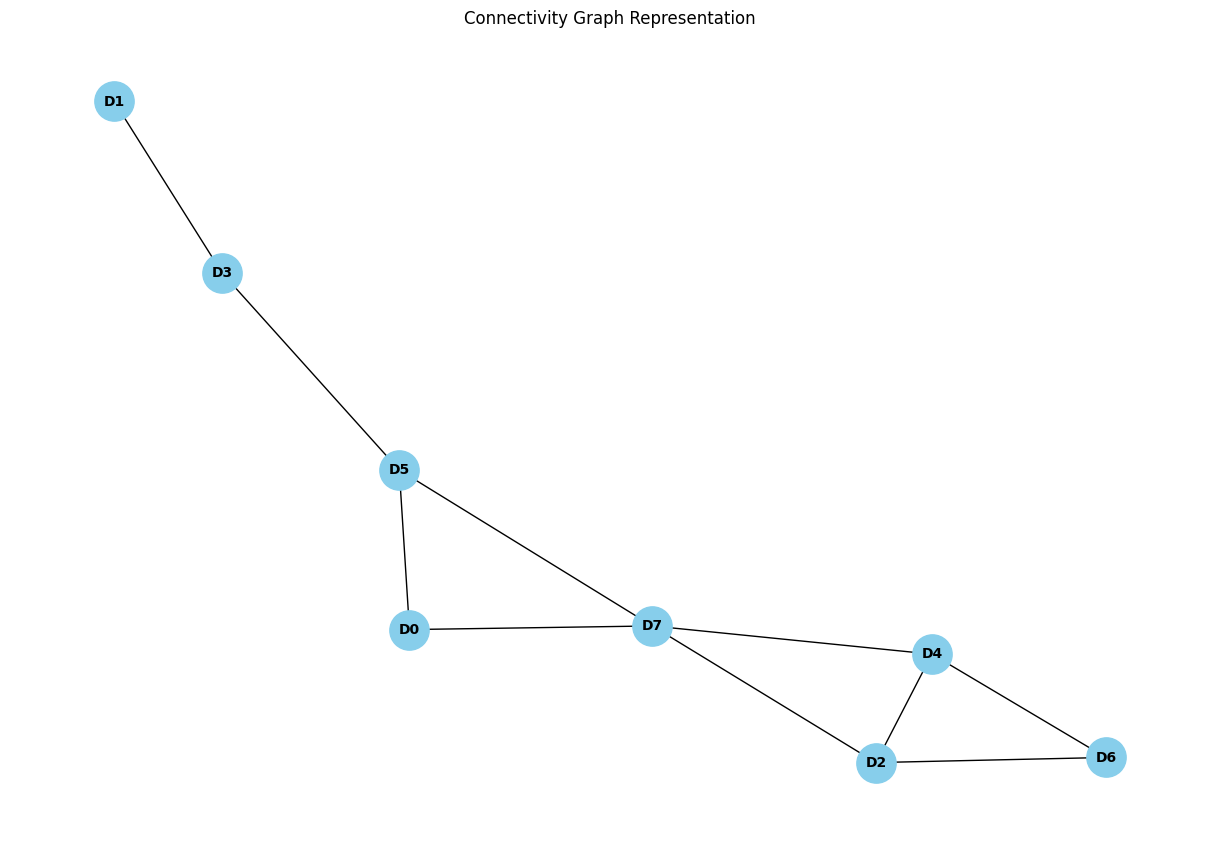

In [9]:
slice_finder.connectivity_graph.draw()

每次选择之后，都更新一次order

In [10]:
slice_finder = SliceFinder(contraction_tree)
slice_finder.slice_based_on_parallelism(sliced_hyperedge_count, updated_order=True)

(21,
 2,
 [[('D0', 'D4')],
  [('D3', 'D7')],
  [('D0', 'D2')],
  [('D1', 'D5')],
  [('D0', 'D7')]])

Order finder，在相邻节点连接相同时，会有一定的随机性。考虑去随机：
1. 选择序号小的？
2. 选择相连超边少的？

我们首先简单实现了前者。通过上述方式，我们发现两种update order能够得到一个较为稳定的解，同时能够保持到与no update order相同的值（虽然我们还不确定这一定是最佳的slice后的值）。